# Celltype Annotation

This tutorial shows how to use BRICK for cell type annotation based on the clustering results of scanpy. Through the differentially expressed genes of each cell cluster, we locate its corresponding cell type.

You can use this turtorial when the user ask : 'Annotate this dataset.'

## Load packages and data 

In [2]:
import BRICK
import scanpy as sc

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)
BRICK.config_llm(modeltype='ChatOpenAI', 
                 api_key="sk-kpsteSkpDGl1xBmDEcC7D51b968e43499092826f17286b55",  
                 base_url='http://10.224.28.80:3000/v1', 
                 llm_params={'model_name': 'qwen-max'})

Graph database has been configured and initialized successfully.
LLM has been configured and initialized successfully.


In [3]:
adata = sc.read('../../../KG_annotation/adata_new1.h5ad')
adata.X = adata.layers['lognorm'].copy() # use log normalized dataset to calculated differential expression gene

In [4]:
adata

AnnData object with n_obs × n_vars = 822 × 14821
    obs: 'sample_name', 'n_genes', 'n_counts', 'annotation', 'leiden', 'KGannotator2', 'delta_specific', 'gamma_specific', 'leiden_combined', 'KGannotator_refinement'
    var: 'Ensembl_id', 'Symbol', 'NCBI_id', 'MGI_id', 'mean', 'std'
    uns: 'KGannotator2_colors', 'KGannotator_refinement_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'annotation_au'
    varm: 'PCs'
    layers: 'lognorm'
    obsp: 'connectivities', 'distances'

## Cell cluster

In [5]:
sc.tl.leiden(adata)

C:\Users\caolei2\AppData\Local\Temp\ipykernel_23868\3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


## Differential expressed gene

In [6]:
sc.tl.rank_genes_groups(adata, groupby='leiden', pts=True)
BRICK.pp.rank_genes_groups2df(adata)

BRICK has implement a function to make the rank_genes_groups result as a dictionary where key is the cell cluster and value is a dataframe to record DEG for each cluster

## Annotation according to the DEG

Take cell cluster 0 as example, we will show how the BRICK works to transform a gene list into a cell type

In [7]:
genelist = BRICK.pp.filter_marker(adata.uns['rank_genes_groups_df']['0'], topgenenumber=10)
genelist

['Meg3',
 'Prss53',
 'Ero1b',
 'Ptprn',
 'Neat1',
 'Chga',
 'Prlr',
 'Syt7',
 'Scg3',
 'Igf1r']

### query graph to get possible celltypes

In [8]:
query_df = BRICK.qr.query_neighbor(genelist, source_entity_type='Gene', relation='marker_of', target_entity_type='Cell')
query_df.head(3)

,path.0.def,path.0.id,path.0.name,path.0.synonym,path.0.type,path.1,path.1.condition,path.1.info_source,path.1.info_source_length,path.1.original_relation,path.1.relation,path.1.relation_confidence,path.2.def,path.2.id,path.2.name,path.2.synonym,path.2.type
0,secretogranin III<loc>:9 D|9 42.32 cM<xref>ENSEMBL:ENSMUSG00000032181|MGI:103032</xref>,NCBI:20255,Scg3,1B1075|Chgd|SgIII,Gene,marker_of,"[Undef, UBERON:0000955]","[Cell_Taxonomy:Human Cell Landscape:PMID:32214235, Cell_Taxonomy:CellMatch:PMID:29775597, SCT000000946]",3,"[marker_of, marker_of, DEG_of]",marker_of,"[1.0, 1.0, 0.617]","A class of large neuroglial (macroglial) cells in the central nervous system - the largest and most numerous neuroglial cells in the brain and spinal cord. Astrocytes (from 'star' cells) are irregularly shaped with many long processes, including those with 'end feet' which form the glial (limiting) membrane and directly and indirectly contribute to the blood-brain barrier. They regulate the extracellular ionic and chemical environment, and 'reactive astrocytes' (along with microglia) respond to injury.<xref>CALOHA:TS-0060|BTO:0000099|FMA:54537</xref>",CL:0000127,astrocyte,astrocytic glia,Cell
1,maternally expressed 3<loc>:12 F1|12 60.25 cM<xref>ENSEMBL:ENSMUSG00000021268|MGI:1202886</xref>,NCBI:17263,Meg3,2900016C05Rik|3110050O07Rik|6330408G06Rik|D12Bwg1266e|Gtl2,Gene,marker_of,[UBERON:0002107],[SCT000000976],1,[DEG_of],marker_of,[0.836],A connective tissue cell which secretes an extracellular matrix rich in collagen and other macromolecules. Flattened and irregular in outline with branching processes; appear fusiform or spindle-shaped.<xref>CALOHA:TS-0362|VHOG:0001482|BTO:0000452|NCIT:C12482|FMA:63877</xref>,CL:0000057,fibroblast,Undef,Cell
2,synaptotagmin VII<loc>:19 A|19 6.58 cM<xref>MGI:1859545|ENSEMBL:ENSMUSG00000024743</xref>,NCBI:54525,Syt7,B230112P13Rik,Gene,marker_of,[UBERON:0003126],"[Cell_Taxonomy:CellMarker:PMID:30069046, Cell_Taxonomy:CellMarker:PMID:30069044, CellMarker:PMID:30069046, CellMarker:PMID:30069044]",4,"[marker_of, marker_of, marker_of, marker_of]",marker_of,"[1, 1, 1, 1]",A neuron that is capable of some hormone secretion in response to neuronal signals.<xref>BTO:0002691|FMA:83810|FBBT:00005130</xref>,CL:0000165,neuroendocrine cell,neurosecretory cell|neurosecretory neuron,Cell


### rank target entity to get the most possible celltype

In [9]:
target_df = BRICK.rk.rank_voting(query_df, metrics=['match_count', 'match_probability', 'info_source_count'], prune_parent=True)

In [10]:
target_df.sort_values('path.2.rank_voting', ascending = True).head(3)

,path.0.name,path.1.relation,path.1.info_source_length,path.1.relation_confidence,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.match_probability,path.2.info_source_count,path.2.rank_voting
144,"[Ptprn, Prlr, Chga, Scg3, Prss53, Syt7, Ero1b, Meg3, Neat1, Igf1r, Chga, Igf1r, Meg3, Prlr, Ptprn, Scg3, Prss53, Syt7, Ero1b]","[marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of]","[2, 3, 2, 2, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 3]","[[1.0, 0.5449999999999999], [1.0, 0.6146, 0.6937], [1.0, 0.598], [1.0, 0.611], [1.0, 0.7399, 0.7978], [1.0, 0.43899999999999995], [1], [0.5070000000000001], [0.44399999999999995], [0.524], [1, 1], [1], [1], [1], [1.0, 0.9508], [1.0, 0.9156], [1.0, 0.9386], [1], [1, 1, 1]]",CL:0000168,type B pancreatic cell,Cell,10,0.044532,33,1.000000
150,"[Chga, Prlr, Ptprn, Scg3, Prss53, Syt7, Ero1b, Meg3, Meg3, Chga, Prlr, Ptprn, Scg3, Prss53, Syt7, Ero1b, Meg3, Chga, Prlr, Ptprn, Scg3, Prss53, Syt7, Ero1b]","[marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]",CL:0000506,type G enteroendocrine cell,Cell,8,0.011198,24,14.166667
45,"[Prss53, Syt7, Scg3, Prlr, Chga, Meg3, Ero1b, Ptprn]","[marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of, marker_of]","[1, 1, 5, 1, 8, 1, 1, 3]","[[1], [1], [1, 1, 1, 1, 1], [1], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7430000000000001, 0.4481], [1], [1], [1, 1, 1]]",CL:0000164,enteroendocrine cell,Cell,8,0.011198,21,14.500000


In [11]:
query_target_df = target_df.sort_values('path.2.rank_voting', ascending = True).head(5)
query_target_df = query_target_df[['path.0.name', 'path.2.name', 'path.2.match_count', 'path.2.match_probability', 'path.2.info_source_count', 'path.2.rank_voting']]


In [12]:
print(BRICK.inp.cell_annotation_analysis(query_target_df))

Based on the queried table, the most reasonable annotation for this cell cluster is **type B pancreatic cell**. Here's the rationale:

1. **Highest Match Count and Probability**: The "type B pancreatic cell" has the highest match count (10) and a higher match probability (0.044532) compared to other candidate cell types, which all have a match probability of 0.011198.

2. **Rank Voting**: The "type B pancreatic cell" also has the highest rank voting score (1.000000), indicating it is the top-ranked candidate.

3. **Subset-Superset Relations**: The other candidate cell types (e.g., type G enteroendocrine cell, enteroendocrine cell, type EC1 enteroendocrine cell, P/D1 enteroendocrine cell) are more general or specific subtypes of enteroendocrine cells. Since "type B pancreatic cell" is a more specific and distinct cell type, it is preferred over the broader categories.

4. **Mixture of Sub-Cell Types**: There is no strong evidence in the data to suggest that this cell cluster is a mixtur

According to the result, the most possible annotation for cluster 0 is type B pancreatic cell

## run cell annotation for all cell clusters 

In [13]:
import tqdm
cellcluster2celltype = {}
cellcluster2annoation_result = {}

for x, y in tqdm.tqdm(adata.uns['rank_genes_groups_df'].items()):
    genelist = BRICK.pp.filter_marker(y, topgenenumber=10)
    query_df = BRICK.qr.query_neighbor(genelist, source_entity_type='Gene', relation='marker_of', target_entity_type='Cell')
    target_df = BRICK.rk.rank_voting(query_df, metrics=['match_count', 'match_probability', 'info_source_count'], prune_parent=True)
    cellcluster2annoation_result[x] = target_df.sort_values('path.2.rank_voting', ascending = True).head(5)
    cellcluster2celltype[x] = list(cellcluster2annoation_result[x]['path.2.name'])[0]

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.32it/s]


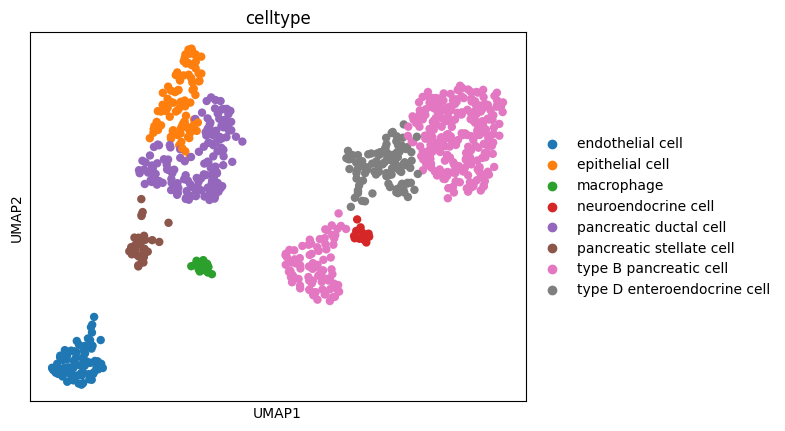

In [14]:
adata.obs['celltype'] = [cellcluster2celltype[x] for x in adata.obs['leiden']]
sc.pl.umap(adata, color = 'celltype')